In [ ]:
# WARNING - HIGHLY EXPERIMENTAL !! USE AT YOUR OWN RISK.

# ======================================================================================================================
# GLAcier Bed EsTimation by varying basal stress. [GLABET]
# ======================================================================================================================


# ======================================================================================================================

#                           Author:
#                        Saugat Paudel
#       M.S. by Research in Glaciology, Kathmandu University, Nepal.
#              Model created as a part of thesis requirement
#                   Email: saugat.email@gmail.com

# ======================================================================================================================
import traceback
import time,gc
import numpy as np
import rasterio
from shapely.ops import  unary_union
from shapely.geometry import shape, mapping, LineString, MultiPolygon, Polygon
import fiona
import subprocess
import os
import math
import csv
from rasterio.mask import mask
from rasterio.crs import CRS
# ======================================================================================================================
__author__ = 'Saugat Paudel'
__version__ = '1.2'
__email__ = 'saugat.email@gmail.com'
__date__ = '6 March 2017'
# ======================================================================================================================


# ======================================================================================================================
# PARAMETERS TO CHANGE.
# ======================================================================================================================

# Paths

# Full Path to the glacier outline shapefile.
glacierOutlineFullPath = '/mnt/d/aru_data/length_area/1991_2015_Aru/smooth/Aru1/ali_smooth_1.shp'


# Full Path to the glacier DEM file. The DEM should preferably have same extent as the outline.
demFullPath = '/mnt/d/aru_data/landsat_clip/Resample_Raster1/autoRIFT_out/dem_clip.tif'

# Full path to the desired output folder.
outputFolder =  '/mnt/d/aru_data/landsat_clip/Resample_Raster1/autoRIFT_dem'
# WARNING - HIGHLY EXPERIMENTAL !! USE AT YOUR OWN RISK.

# Parameters
density = 900  # In kilograms per cubic meters. Default: 900
f = 0.8  # Dimensionless. Default: 0.8
g = 9.81  # Acceleration due to gravity in meters per seconds squared. Default: 9.81

# ======================================================================================================================
# ======================================================================================================================


# ======================================================================================================================
# Other variables. Not necessary to change.
# ======================================================================================================================

# Path to 'nnbathy' interpolation algorithm
'''
The nnbathy algorithm is included within the model folder. See glabet/nnbathy. In windows it may be necessary 
to change the slashes in the folder structure. Also it may be necessary to put '.exe' at the end. This depends on how 
the nnbathy algorithm was compiled.

Look in the 'nnbathy' help/readme to find out more about compilation
'''

# Give the relative path to the 'nnbathy' interpolation algorithm here. Edit 'nnbathy/nnbathy' part.
nnPATH = '/home/slw/software/nn-c/nn/nnbathy'


# Output File Paths.
contourFullPath = os.path.join(outputFolder, 'contour.shp')
slopeFullPath = os.path.join(outputFolder, 'slope.tif')
sampledCSV = os.path.join(outputFolder, 'ungriddedCSV.txt')
finalCSV = os.path.join(outputFolder, 'finalCSV.txt')
thicknessRaster = os.path.join(outputFolder, 'Thickness.tif')
bedTopoFullPath = os.path.join(outputFolder, 'BedTopo.tif')
bufferedOutlineFullPath = os.path.join(outputFolder, 'bufferedOutline.shp')

# ======================================================================================================================
# FUNCTION DECLARATIONS. ALL REQUIRED FUNCTIONS ARE BELOW THIS LINE.
# ======================================================================================================================


# Check for the necessary files. This does not check the existence of the output folder.
def checkFiles():
    if os.path.exists(glacierOutlineFullPath) is False:
        print('Glacier outline not found!! Model will now exit.')
        exit()
    elif os.path.exists(demFullPath) is False:
        print('DEM not found!! Model will now exit.')
        exit()
    else:
        pass
    return None


# Check if the model was previously run and if there is existing data in the output folder.
def cleanUp():
    if os.path.exists(outputFolder):
        if os.path.dirname(glacierOutlineFullPath) == outputFolder or os.path.dirname(demFullPath) == outputFolder:
            print('Input data cannot be in the output folder. Please give a different folder path.')
            print('Model will now exit.')
            exit()
        print('\nThe output folder already exists.\n')
        print('WARNING: The output folder will be DELETED and RECREATED. \n'
              'Backup all the data contained in this folder.')
        decision='n'
        if decision == 'y':
            subprocess.call(['rm', '-r', outputFolder])
            os.mkdir(outputFolder)
        else:
            print('output folder not changed. Model will now exit.')
            exit()
    else:
        os.mkdir(outputFolder)
    return print('\nOutput folder is created .. OK!')


# Create contour from the given DEM. For this function to work 'gdal' libraries needs to be installed.
def createContour(pathToDEMFile, outputPath, contourInterval):
    subprocess.call(
        ['gdal_contour', '-a', 'elevation', '-i', str(contourInterval), '-f', 'ESRI Shapefile', pathToDEMFile,
         outputPath], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return print('Contour shapefile is created ... OK!')


# Create slope from the given DEM. For this function to work 'gdal' libraries needs to be installed.
def createSlope(pathToDEMFile, outputPath):
    subprocess.call(['gdaldem', 'slope', pathToDEMFile, outputPath, '-of', 'GTiff', '-compute_edges'],
                    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return print('Slope raster is created ... OK!')


# Get the exterior coordinates of the glacier outline shapefile.
def getPolygonExteriorCoords(fionaFeature):
    """
    输入：fiona feature
    输出：所有 Polygon / MultiPolygon 的外边界 LineString 列表
    """
    polygon = shape(fionaFeature["geometry"])
    exterior_lines = []

    if polygon.geom_type == "Polygon":
        # 单 Polygon
        exterior_lines.append(LineString(polygon.exterior.coords))

    elif polygon.geom_type == "MultiPolygon":
        # MultiPolygon 必须使用 polygon.geoms 来迭代
        for subpoly in polygon.geoms:
            exterior_lines.append(LineString(subpoly.exterior.coords))

    else:
        raise TypeError(f"Unsupported geometry type: {polygon.geom_type}")

    return exterior_lines
# Get the interior coordinates of the glacier outline shapefile.
# This is needed in cases where the glacier has internal rings inside the boundary. Compare 'ponkar' and 'mera' glacier
# to see the differences
# def getPolygonInteriorCoords(fionaFeature):
#     interiorRings = []
#     polygon = shape(fionaFeature['geometry'])
#     if polygon.geom_type == 'Polygon':
#         for interiorCoords in polygon.interiors:
#             interiorRings.append(LineString(interiorCoords))
#     elif polygon.geom_type == 'MultiPolygon':
#         for individualPolygons in polygon:
#             for interiorCoords in individualPolygons.interiors:
#                 interiorRings.append(LineString(interiorCoords))
#     else:
#         print('WARNING: at function "getPolygonInteriorCoords", supported geometry not found!! Returning empty list.')
#         pass
#     return interiorRings

# def getPolygonInteriorCoords(fionaFeature):
#     """
#     输出 MultiPolygon 或 Polygon 的所有内环（洞）
#     """
#     polygon = shape(fionaFeature["geometry"])
#     interior_lines = []

#     if polygon.geom_type == "Polygon":
#         for ring in polygon.interiors:
#             interior_lines.append(LineString(ring.coords))

#     elif polygon.geom_type == "MultiPolygon":
#         for subpoly in polygon.geoms:
#             for ring in subpoly.interiors:
#                 interior_lines.append(LineString(ring.coords))

#     else:
#         raise TypeError(f"Unsupported geometry type: {polygon.geom_type}")

#     return interior_lines


def getPolygonExteriorCoords(fionaFeature):
    polygon = shape(fionaFeature["geometry"])
    polygonExteriorCoords = []

    # 单个Polygon
    if polygon.geom_type == 'Polygon':
        polygonExteriorCoords.append(LineString(list(polygon.exterior.coords)))

    # MultiPolygon：必须使用 polygon.geoms 遍历
    elif polygon.geom_type == 'MultiPolygon':
        for poly in polygon.geoms:
            polygonExteriorCoords.append(LineString(list(poly.exterior.coords)))

    return polygonExteriorCoords



def getPolygonInteriorCoords(feature):
    """
    返回每个 polygon 的内环（holes）作为 LineString 列表
    支持 Fiona feature dict / shapely Polygon / MultiPolygon / GeometryCollection
    """
    # 1) 处理 fiona feature
    if isinstance(feature, dict) and "geometry" in feature:
        geom_json = feature.get("geometry")
        if geom_json is None:
            return []
        try:
            geom = shape(geom_json)
        except Exception:
            return []
    else:
        geom = feature

    if not hasattr(geom, "geom_type"):
        return []

    interior_lines = []

    if geom.geom_type == "Polygon":
        for ring in geom.interiors:
            interior_lines.append(LineString(list(ring.coords)))
    elif geom.geom_type == "MultiPolygon":
        for subpoly in geom.geoms:
            for ring in subpoly.interiors:
                interior_lines.append(LineString(list(ring.coords)))
    elif geom.geom_type == "GeometryCollection":
        for part in geom.geoms:
            if part.geom_type == "Polygon":
                for ring in part.interiors:
                    interior_lines.append(LineString(list(ring.coords)))
            elif part.geom_type == "MultiPolygon":
                for subpoly in part.geoms:
                    for ring in subpoly.interiors:
                        interior_lines.append(LineString(list(ring.coords)))
    else:
        return []

    return interior_lines


# 
# Read the metadata of the given DEM. Includes all necessary information such as resolution, extents, etc.
def getRasterMetadata(rasterFileFullPath):
    with rasterio.open(rasterFileFullPath) as rasterFile:
        rasterMetadata = rasterFile.meta.copy()
    return rasterMetadata


# Check if the raster file is in projected coordinate system. Model does not work for GCS projection.
# TODO: Check shapefile as well.
def checkRasterProjection(rasterFileFullPath):
    rasterMetaData = getRasterMetadata(rasterFileFullPath)
    rasterCRS = rasterMetaData['crs']
    print('DEM is not in projected Coordinate system. Please make sure it is! Model will now exit ...') or exit() \
        if rasterCRS.is_projected is False else None
    return print('Raster projected seem to be OK!')


# Get cosine values when input is in degrees.
def cosd(angleInDegrees):
    cosD = math.cos(math.radians(angleInDegrees))
    return cosD


# Get sine values when input is in degrees.
def sind(angleInDegrees):
    sinD = math.sin(math.radians(angleInDegrees))
    return sinD


# Get the mean raster slope. This is used in the estimation of the basal stress.
def getMeanRasterSlope(rasterioRasterObject, shapelyPolygonObject, returnMetaData=False):
    rasterMetaData = rasterioRasterObject.meta.copy()
    polygon = [mapping(shapelyPolygonObject)]
    maskedRaster, maskedRasterAffine = mask(rasterioRasterObject, polygon, nodata=np.nan)
    rasterMetaData.update({
        'driver': 'GTiff',
        'height': maskedRaster.shape[1],
        'width': maskedRaster.shape[2],
        'transform': maskedRasterAffine
    })
    meanRasterSlope = np.nanmean(maskedRaster)
    if returnMetaData:
        return meanRasterSlope, rasterMetaData
    else:
        return meanRasterSlope


# The changing outline of the glacier.
def createBufferedOutlines(inputShapefile, outputShapefile, rasterFileFullPath, bufferedist):
    with fiona.open(inputShapefile) as shapefile:
        driver = shapefile.driver
        crs = shapefile.crs
        schema = {'properties': {'ID': 'int', 'area': 'float', 'tau': 'float'}, 'geometry': 'MultiPolygon'}
        errorMsg = 'Given shapefile of the glacier outline contains more than 1 feature, ' \
                   'please ensure that the file has only one geometry \nModel will now exit...'
        print(errorMsg) or exit() if shapefile.__len__() != 1 else None
        with fiona.open(outputShapefile, 'w', crs=crs, schema=schema, driver=driver) as output:
            with rasterio.open(rasterFileFullPath) as raster:
                for features in shapefile:
                    outlineshape = shape(features['geometry'])
                    unionedpoly = unary_union([outlineshape])
                    initialArea = outlineshape.area
                    fid = 0
                    while unary_union([outlineshape.buffer(bufferedist)]).type != 'GeometryCollection':
                        # 计算tau
                        tau = (2.7e4) * (((initialArea - unionedpoly.area) /
                                        cosd(getMeanRasterSlope(raster, unionedpoly))) ** 0.106)

                        # 输出统一为 MultiPolygon
                        geom_to_write = unionedpoly
                        if geom_to_write.geom_type == 'Polygon':
                            geom_to_write = MultiPolygon([geom_to_write])

                        output.write({
                            'properties': {
                                'ID': fid,
                                'area': initialArea - unionedpoly.area,
                                'tau': tau,
                            },
                            'geometry': mapping(geom_to_write)
                        })

                        fid += 1

                        # 继续缓冲
                        new_outline = outlineshape.buffer(bufferedist)
                        if new_outline.is_empty:
                            break

                        unionedpoly = unary_union([new_outline])

                        # 统一类型
                        if unionedpoly.geom_type == 'Polygon':
                            outlineshape = unionedpoly
                        else:
                            outlineshape = unionedpoly

                        if unionedpoly.is_empty:
                            break

                        # tau = (2.7 * 10 ** 4) * (((initialArea - unionedpoly.area) /
                        #                           cosd(getMeanRasterSlope(raster, unionedpoly))) ** 0.106)
                        # output.write({
                        #     'properties':
                        #         {
                        #             'ID': fid,
                        #             'area': initialArea - unionedpoly.area,
                        #             'tau': tau,
                        #         },
                        #     'geometry': mapping(unionedpoly)
                        # })
                        # unionedpoly = (unary_union([outlineshape.buffer(bufferedist)]))
                        # outlineshape = outlineshape.buffer(bufferedist)
                        # fid += 1
    return print('Buffered outline is created ... OK!')


# Pick raster values at given coordinates
def sampleRaster(rasterioRasterObject, samplingCoordX, samplingCoordY, band=1):
    rasterData = rasterioRasterObject.read(band)
    indexX, indexY = rasterioRasterObject.index(samplingCoordX, samplingCoordY)
    rasterValue = rasterData[indexX][indexY]
    return rasterValue


# Averaged slope at given coordinate. See description for more details.
def averagedSlopeSample(rasterObject, samplingCoordinateX, samplingCoordinateY, first=5, second=10, third=20, band=1):
    """
    Returns single averaged raster value at sampled point. Average is done at 3x3, 5x5 and 7x7 raster grid.

    The averaging is done based on the following:
        1. average a 7x7 grid if value is less than 'first'. Default: 5 (in degrees for slope)
        2. average a 5x5 grid if value is less than 'second'. Default: 10 (in degrees for slope)
        3. average a 3x3 grid if value is less than 'third'. Default: 20 (in degrees for slope)
        4. do not average if value exceeds 'third'. ie use the exact slope value
    The grid is defined in the 'grid3x3', 'grid5x5', and 'grid7x7' variables in the function itself. modifying these
    variables will give average at that grid.
    i.e grid3x3 = [2, 5] ==> will give values averaged at:
                             2 * 2 + 1 by 2 * 5 + 1 grid
                              i.e 5 x 11 grid.
    Defaults:
        grid3x3 = [1, 1] => implies 2 * 1 + 1,  2 * 1 + 1 = 3x3 grid.
        grid5x5 = [2, 2] => implies 2 * 2 + 1,  2 * 3 + 1 = 5x5 grid.
        grid7x7 = [3, 3] => implies 2 * 3 + 1,  2 * 3 + 1 = 7x7 grid.

    :param rasterObject: rasterio raster object. open the slope raster with rasterio.
    :param samplingCoordinateX: x-coordinate of the point from where the value of slope is required.
    :param samplingCoordinateY: y-coordinate of the point from where the value of slope is required.
    :param band: The band of raster. Default is 1.
    :param first: Value less than for which averaging is done with a 7x7 grid
    :param second: Value less than for which averaging is done with a 5x5 grid
    :param third:
    :returns: returns single averaged raster value at sampled point. Average is done at 3x3, 5x5 and 7x7 raster grid.
    """
    sumSlope = 0
    grid3x3 = [1, 1]
    grid5x5 = [2, 2]
    grid7x7 = [3, 3]
    rasterBand = rasterObject.read(band)
    indexX, indexY = rasterObject.index(samplingCoordinateX, samplingCoordinateY)
    slopeValue = rasterBand[indexX][indexY]
    if slopeValue <= first:
        count = 0
        for xIndices in range(indexX - (grid7x7[0]), indexX + (grid7x7[0] + 1)):
            for yIndices in range(indexY - (grid7x7[1]), indexY + (grid7x7[1] + 1)):
                if 0 <= xIndices <= rasterBand.shape[0] and 0 <= yIndices <= rasterBand.shape[1]:
                    try:
                        if rasterBand[xIndices][yIndices] == rasterObject.get_nodatavals() \
                                or rasterBand[xIndices][yIndices] == np.nan:
                            pass
                        else:
                            count += 1
                            sumSlope = sumSlope + np.nansum(rasterBand[xIndices][yIndices])
                    except IndexError:
                        print('WARNING: Index Exceeded at', samplingCoordinateX, samplingCoordinateY,
                              'resulting index was ', indexX, indexY)
                else:
                    pass
        try:
            averageSlope = sumSlope / count
        except ZeroDivisionError:
            print('WARNING: No Slope data found for ', grid7x7[0], 'x', grid7x7[1],
                  ' grid. Returning the exact slope at sampling points')
            averageSlope = slopeValue.astype(np.float64)
    elif slopeValue < second:
        count = 0
        for xIndices in range(indexX - (grid5x5[0]), indexX + (grid5x5[0] + 1)):
            for yIndices in range(indexY - (grid5x5[1]), indexY + (grid5x5[1] + 1)):
                if 0 <= xIndices <= rasterBand.shape[0] and 0 <= yIndices <= rasterBand.shape[1]:
                    try:
                        if rasterBand[xIndices][yIndices] == rasterObject.get_nodatavals() \
                                or rasterBand[xIndices][yIndices] == np.nan:
                            pass
                        else:
                            count += 1
                            sumSlope = sumSlope + np.nansum(rasterBand[xIndices][yIndices])
                    except IndexError:
                        print('WARNING: Index Exceeded at', samplingCoordinateX, samplingCoordinateY,
                              'resulting index was ', indexX, indexY)
                else:
                    pass
        try:
            averageSlope = sumSlope / count
        except ZeroDivisionError:
            print('WARNING: No Slope data found for ', grid5x5[0], 'x', grid5x5[1],
                  ' grid. Returning the exact slope at sampling points')
            averageSlope = slopeValue.astype(np.float64)
    elif slopeValue < third:
        count = 0
        for xIndices in range(indexX - (grid3x3[0]), indexX + (grid3x3[0] + 1)):
            for yIndices in range(indexY - (grid3x3[1]), indexY + (grid3x3[1] + 1)):
                if 0 <= xIndices < rasterBand.shape[0] and 0 <= yIndices < rasterBand.shape[1]:
                    try:
                        if rasterBand[xIndices][yIndices] == rasterObject.get_nodatavals() \
                                or rasterBand[xIndices][yIndices] == np.nan:
                            pass
                        else:
                            count += 1
                            sumSlope = sumSlope + np.nansum(rasterBand[xIndices][yIndices])
                    except IndexError:
                        print('WARNING: Index Exceeded at', samplingCoordinateX, samplingCoordinateY,
                              'resulting index was ', indexX, indexY)
                else:
                    pass
        try:
            averageSlope = sumSlope / count
        except ZeroDivisionError:
            print('WARNING: No Slope data found for ', grid3x3[0], 'x', grid3x3[1],
                  ' grid. Returning the exact slope at sampling points')
            averageSlope = slopeValue.astype(np.float64)
    else:
        averageSlope = slopeValue.astype(np.float64)
    return averageSlope


def getSamplePoints(shapelyGeometryWithLineStrings1, shapelyGeometryWithLineStrings2):
    x, y = [], []
    for features in shapelyGeometryWithLineStrings1:
        outlineShape = shape(features['geometry'])
        for individualContours in shapelyGeometryWithLineStrings2:
            contourShape = shape(individualContours['geometry'])
            intersectionX, intersectionY = contourShape.intersection(outlineShape)
            x.append(intersectionX) if intersectionX else None
            y.append(intersectionY) if intersectionY else None
    return x, y


# After sampling the thickness values at few points, the sampled points are interpolated to get a gridded data.
# 'nnbathy' algorithm is used here.
def interpolateUngriddedData(inputCSVFile, outputCSVFile, metaData):
    gridWidth = metaData['width']
    gridHeight = metaData['height']
    xMin = metaData['transform'][2]
    xMax = xMin + metaData['transform'][0] * gridWidth
    yMax = metaData['transform'][5]
    yMin = yMax + metaData['transform'][4] * gridHeight
    cmd = str(gridWidth) + 'x' + str(gridHeight)
    with open(outputCSVFile, 'w') as interpolatedCSV:
        subprocess.call([nnPATH, '-i', inputCSVFile, '-n', cmd, '-x', str(xMax), str(xMin), '-y', str(yMax),
                         str(yMin), '-W', '0'], stdout=interpolatedCSV)
    return print('Interpolation is completed ... OK!')


# Create a raster file from the gridded thickness data.
def createRaster(griddedData, outputRasterFullPath, metaData):
    data = np.loadtxt(griddedData)
    metaData.update({'dtype': 'float64', 'nodata': np.nan})
    pointThicknessValues = np.fliplr(np.reshape(data[:, 2], (metaData['height'], metaData['width'])))
    with rasterio.open(outputRasterFullPath, 'w', **metaData) as thicknessObject:
        thicknessObject.write(pointThicknessValues, 1)
    return print('Thickness raster is created ... OK!')


# Subtract the thickness raster from DEM to get Bed Topography.
def subtractRasters(firstRasterFullPath, secondRasterFullPath, outputRasterFullPath, firstBand=1, secondBand=1):
    with rasterio.open(firstRasterFullPath) as firstRaster:
        with rasterio.open(secondRasterFullPath) as secondRaster:
            rasterMetaData = firstRaster.meta.copy()
            rasterMetaData.update({'dtype': 'float64', 'nodata': np.nan})
            with rasterio.open(outputRasterFullPath, 'w', **rasterMetaData) as outputRaster:
                firstRasterData = firstRaster.read(firstBand)
                secondRasterData = secondRaster.read(secondBand)
                firstRasterData[firstRasterData == firstRaster.get_nodatavals()] = np.nan
                secondRasterData[secondRasterData == secondRaster.get_nodatavals()] = np.nan
                outputData = firstRasterData - secondRasterData
                outputRaster.write(outputData, 1)
    return print('Bed topograpgy is created ... OK!')


def main():

    # Check if input files are ok.
    checkFiles()

    # Create output folder.
    cleanUp()

    # To get the time taken by the model
    startTime = time.perf_counter()

    # Get raster meta data
    rasterMetaData = getRasterMetadata(demFullPath)

    # Check if the given raster is projected.
    checkRasterProjection(demFullPath)

    # Create contours.
    createContour(demFullPath, contourFullPath, rasterMetaData['transform'][0])

    # Create slope.
    createSlope(demFullPath, slopeFullPath)

    # Create buffered outlines
    createBufferedOutlines(glacierOutlineFullPath, bufferedOutlineFullPath,
                           slopeFullPath, rasterMetaData['transform'][4])

    # Main section, where the magic happens
    with fiona.open(bufferedOutlineFullPath) as bufferedPolygons, \
        fiona.open(contourFullPath) as contours, \
        rasterio.open(slopeFullPath) as slopeRaster, \
        open(sampledCSV, 'w') as ungriddedCSV, \
        fiona.open(glacierOutlineFullPath) as glacierOutline:
            writeCSV = csv.writer(ungriddedCSV, delimiter=' ')

            # Set the ice thickness at glacier boundary to zero.
            for features in glacierOutline:
                featureGeom = shape(features['geometry'])
                exteriorCoords = featureGeom.exterior.coords
                for points in exteriorCoords:
                    writeCSV.writerow([points[0], points[1], 0])
                interiorGeom = featureGeom.interiors
                for intFeat in interiorGeom:
                    interiorCoords = intFeat.coords
                    for points in interiorCoords:
                        writeCSV.writerow([points[0], points[1], 0])

            # Get ice thickness at various sampling points.
            for individualFeature in bufferedPolygons:
                externalLines = getPolygonExteriorCoords(individualFeature)
                internalLines = getPolygonInteriorCoords(individualFeature)
                for individualContour in contours:
                    intersectionPoints = []
                    singleContour = shape(individualContour['geometry'])
                    for individualLines in externalLines:
                        intersectionPoints.append(singleContour.intersection(individualLines))
                    if not internalLines:
                        for individualLines in internalLines:
                            intersectionPoints.append(singleContour.intersection(individualLines))
                    for points in intersectionPoints:
                        if points.is_empty is False:
                            if points.geom_type == 'Point':
                                slope = averagedSlopeSample(slopeRaster, points.xy[0][0], points.xy[1][0])
                                h = individualFeature['properties']['tau']/(density * f * sind(slope) * g)
                                writeCSV.writerow([points.xy[0][0], points.xy[1][0], h])
                            elif points.geom_type == 'MultiPoint':
                                for individualPoints in points:
                                    slope = averagedSlopeSample(slopeRaster, individualPoints.xy[0][0],
                                                                individualPoints.xy[1][0])
                                    h = individualFeature['properties']['tau'] / (density * f * sind(slope) * g)
                                    writeCSV.writerow([individualPoints.xy[0][0], individualPoints.xy[1][0], h])
                            else:
                                print('WARNING: Neither "Point" or "MultiPoint". Doing Nothing!!')
                                pass
    print('Sampling is completed ... OK!')

    # Interpolate the un-gridded data
    interpolateUngriddedData(sampledCSV, finalCSV, rasterMetaData)

    # Create thickness raster.
    createRaster(finalCSV, thicknessRaster, rasterMetaData)

    # Create Bed Topography
    subtractRasters(demFullPath, thicknessRaster, bedTopoFullPath)

    # Total time taken by the model
    print('\nTotal time elapsed = ', time.perf_counter() - startTime, ' seconds')

if __name__ == '__main__':
    main()

In [ ]:
pip install fiona

In [ ]:
# -*- coding: utf-8 -*-
"""
OGGM GlabTop 冰川厚度生成脚本
输入：冰川 RGI ID
输出：ice_thickness.tif, bed_dem.tif
"""
from oggm import cfg, utils, workflow, graphics, tasks, DEFAULT_BASE_URL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from oggm import cfg, utils, workflow, tasks
from oggm.core import gis
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
import os
from oggm.core import inversion
import salem
import glob
import xarray as xr
import rioxarray as rioxr
# -----------------------------
# 1. 配置工作目录和 OGGM 参数
# -----------------------------
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
# 初始化
cfg.PATHS['working_dir'] = '/mnt/d/area/glims/glenglat_asia'
cfg.PARAMS['use_intersects'] = False
# rgi_ids = ["RGI60-13.48434"]
rgi_ids = ["RGI60-13.53249"]
'''
RGI60-13.53249
RGI60-13.53249
RGI60-15.09026
RGI60-13.54211
RGI60-13.49367
RGI60-13.54364
RGI60-13.53222


'''
# Geometrical centerline
# Where to store the data 

# We start from prepro level 3 with all data ready - note the url here
#base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/'
#base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/2025.6/elev_bands_w_data/RGI70G/b_080/'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3,prepro_border=160,prepro_base_url=base_url)

# to assess the model geometry (for e.g. distributed ice thickness plots),
# we need to set that to true
#cfg.PARAMS['store_model_geometry'] = True
#workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)

# Default parameters
# Deformation: from Cuffey and Patterson 2010
glen_a = 2.4e-24
# Sliding: from Oerlemans 1997
fs = 5.7e-20
# Distribute
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
# xarray is an awesome library! Did you know about it?

ds = xr.open_dataset(gdirs[0].get_filepath('gridded_data'))
ds.distributed_thickness.plot();
# save the distributed ice thickness into a geotiff file
workflow.execute_entity_task(tasks.gridded_data_var_to_geotiff, gdirs, varname='distributed_thickness')

# The default path of the geotiff file is in the glacier directory with the name "distributed_thickness.tif"
# Let's check if the file exists
for gdir in gdirs:
    path = os.path.join(gdir.dir, "distributed_thickness.tif")
    assert os.path.exists(path)

In [ ]:
# -*- coding: utf-8 -*-
"""
OGGM GlabTop 冰川厚度生成脚本
输入：冰川 RGI ID
输出：ice_thickness.tif, bed_dem.tif
"""
from oggm import cfg, utils, workflow, graphics, tasks, DEFAULT_BASE_URL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from oggm.core import gis,inversion
import pandas as pd
import oggm,os,salem,glob
import rioxarray as rioxr


# -----------------------------
# 1. 配置工作目录和 OGGM 参数
# -----------------------------
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
# 初始化
cfg.PATHS['working_dir'] = '/mnt/d/area/glims/glenglat_asia'
cfg.PARAMS['use_intersects'] = False
# rgi_ids = ["RGI60-13.48434"]

rgi_list=['RGI60-13.53249','RGI60-15.09026','RGI60-13.54211','RGI60-13.49367','RGI60-13.54364','RGI60-13.53222']
for i in range(len(rgi_list)):
    rgi_ids = [str(rgi_list[i])]
    # Geometrical centerline
    # Where to store the data 

    # We start from prepro level 3 with all data ready - note the url here
    base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
    #base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/'
    #base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/2025.6/elev_bands_w_data/RGI70G/b_080/'
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3,prepro_border=160,prepro_base_url=base_url)

    # to assess the model geometry (for e.g. distributed ice thickness plots),
    # we need to set that to true
    #cfg.PARAMS['store_model_geometry'] = True
    #workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)

    # Default parameters
    # Deformation: from Cuffey and Patterson 2010
    glen_a = 2.4e-24
    # Sliding: from Oerlemans 1997
    fs = 5.7e-20
    # Distribute
    workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
    # xarray is an awesome library! Did you know about it?

    ds = xr.open_dataset(gdirs[0].get_filepath('gridded_data'))
    # 
    # save the distributed ice thickness into a geotiff file
    workflow.execute_entity_task(tasks.gridded_data_var_to_geotiff, gdirs, varname='distributed_thickness')
    ds.distributed_thickness.plot();
    # The default path of the geotiff file is in the glacier directory with the name "distributed_thickness.tif"
    # Let's check if the file exists
    for gdir in gdirs:
        path = os.path.join(gdir.dir, "distributed_thickness.tif")
        assert os.path.exists(path)

2025-12-11 10:01:55: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-12-11 10:01:55: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-12-11 10:01:55: oggm.cfg: Multiprocessing: using all available processors (N=20)
2025-12-11 10:01:55: oggm.cfg: Multiprocessing switched ON after user settings.
2025-12-11 10:01:55: oggm.cfg: Multiprocessing: using the requested number of processors (N=12)
2025-12-11 10:01:55: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2025-12-11 10:01:56: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 10:01:56: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 10:01:57: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-12-11 10:01:57: oggm.workflow: Execute entity tasks [gridded_data_var_to_geotiff] on 1 glaciers
2025-12-11 10:01:57: oggm.utils: Applying global task writ

中心线已导出！


2025-12-11 10:01:58: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 10:01:58: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 10:01:58: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-12-11 10:01:59: oggm.workflow: Execute entity tasks [gridded_data_var_to_geotiff] on 1 glaciers
2025-12-11 10:01:59: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 10:01:59: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/glacier_centerlines.shp ...
2025-12-11 10:01:59: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线已导出！


2025-12-11 10:02:00: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 10:02:00: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 10:02:00: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-12-11 10:02:01: oggm.workflow: Execute entity tasks [gridded_data_var_to_geotiff] on 1 glaciers
2025-12-11 10:02:01: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 10:02:01: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/glacier_centerlines.shp ...
2025-12-11 10:02:01: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线已导出！


2025-12-11 10:02:02: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 10:02:02: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 10:02:02: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-12-11 10:02:03: oggm.workflow: Execute entity tasks [gridded_data_var_to_geotiff] on 1 glaciers
2025-12-11 10:02:03: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 10:02:03: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/glacier_centerlines.shp ...
2025-12-11 10:02:03: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线已导出！


2025-12-11 10:02:04: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 10:02:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 10:02:04: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-12-11 10:02:05: oggm.workflow: Execute entity tasks [gridded_data_var_to_geotiff] on 1 glaciers
2025-12-11 10:02:05: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 10:02:05: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/glacier_centerlines.shp ...
2025-12-11 10:02:05: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线已导出！


2025-12-11 10:02:06: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 10:02:06: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 10:02:06: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-12-11 10:02:07: oggm.workflow: Execute entity tasks [gridded_data_var_to_geotiff] on 1 glaciers
2025-12-11 10:02:07: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 10:02:07: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/glacier_centerlines.shp ...
2025-12-11 10:02:07: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线已导出！


2025-12-11 11:25:59: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-12-11 11:25:59: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-12-11 11:25:59: oggm.cfg: Multiprocessing: using all available processors (N=20)
2025-12-11 11:25:59: oggm.cfg: Multiprocessing switched ON after user settings.
2025-12-11 11:25:59: oggm.cfg: Multiprocessing: using the requested number of processors (N=12)
2025-12-11 11:25:59: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2025-12-11 11:26:00: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:26:00: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:26:01: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:26:01: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline.sh

中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline.shp


2025-12-11 11:26:03: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:26:03: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:26:03: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:26:03: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline.shp ...
2025-12-11 11:26:03: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline.shp


2025-12-11 11:26:04: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:26:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:26:05: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:26:05: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline.shp ...
2025-12-11 11:26:05: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline.shp


2025-12-11 11:26:07: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:26:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:26:07: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:26:07: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline.shp ...
2025-12-11 11:26:07: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline.shp


2025-12-11 11:26:09: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:26:09: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


PermissionError: [Errno 13] Permission denied: 'RGI60-13.49367_centerline.shp.MS-COMPUTER.39176.33636.sr.lock'

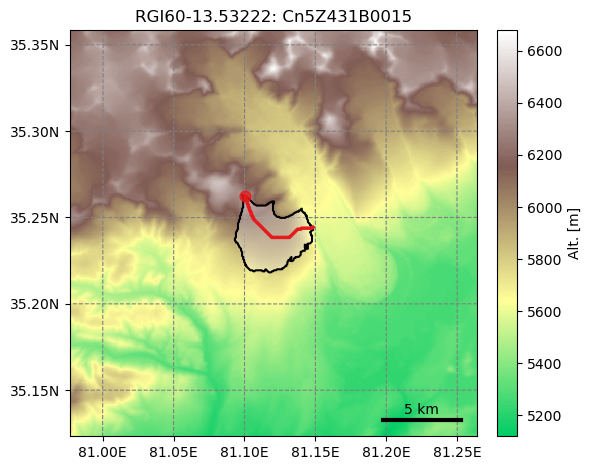

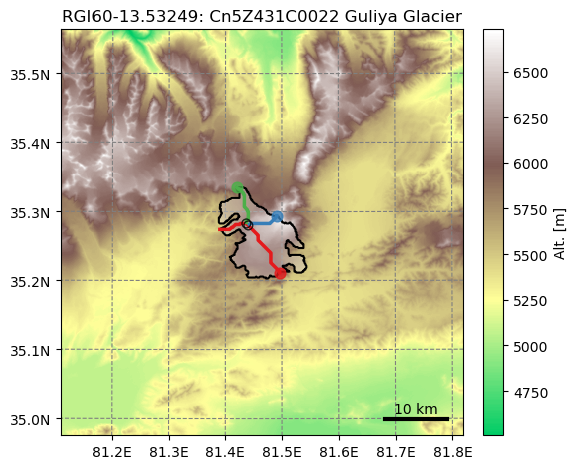

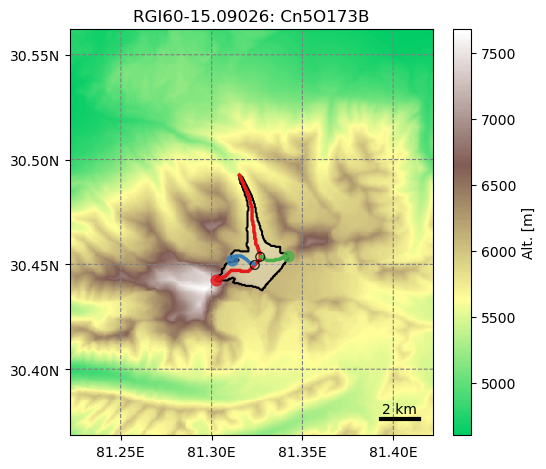

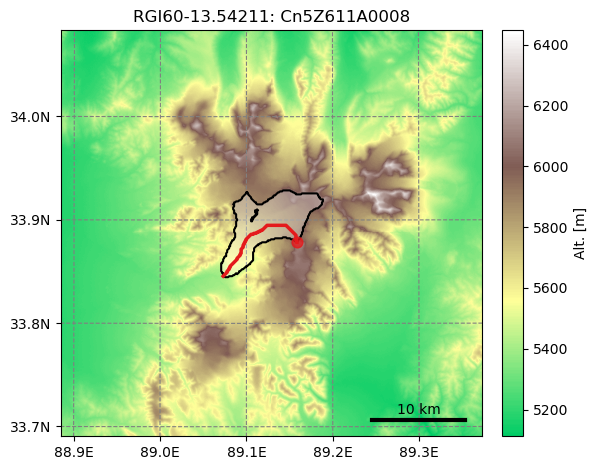

In [19]:
# -*- coding: utf-8 -*-
"""
OGGM GlabTop 冰川厚度生成脚本
输入：冰川 RGI ID
输出：ice_thickness.tif, bed_dem.tif
"""
from oggm import cfg, utils, workflow, graphics, tasks, DEFAULT_BASE_URL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from oggm.core import gis,inversion
import pandas as pd
import oggm,os,salem,glob,shutil
import rioxarray as rioxr

# -----------------------------
# 1. 配置工作目录和 OGGM 参数
# -----------------------------
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
# 初始化
cfg.PATHS['working_dir'] = '/mnt/d/area/glims/glenglat_asia'
cfg.PARAMS['use_intersects'] = False
# rgi_ids = ["RGI60-13.48434"]

rgi_list=['RGI60-13.53249','RGI60-15.09026','RGI60-13.54211','RGI60-13.49367','RGI60-13.54364','RGI60-13.53222']
for i in range(len(rgi_list)):

    # Geometrical centerline
    # Where to store the data 

    # We start from prepro level 3 with all data ready - note the url here
    base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
    #base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/'
    #base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/2025.6/elev_bands_w_data/RGI70G/b_080/'
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3,prepro_border=160,prepro_base_url=base_url)
    gdir = gdirs[0]
    rgi_ids = [str(rgi_list[i])]
    srcpath = gdir.get_filepath('centerlines')
    new_name = os.path.dirname(srcpath)+'/'+f"{gdir.rgi_id}_centerline.shp"
    utils.write_centerlines_to_shape(gdirs,  # The glaciers to process
                                    path=new_name,  # The output file
                                    ensure_exterior_match=True,
                                    to_tar=False,  # set to True to put everything into one single tar file
                                    simplify_line_before=0.75,# Write into the projection of the original inventory
                                    simplify_line_after = 0.0,
                                    keep_main_only=True,  # Write only the main flowline and discard the tributaries
                                    corner_cutting=3
                                    )

    print("中心线文件：", new_name)
    cls_smooth = gpd.read_file(new_name)
    graphics.plot_centerlines(gdir)

In [29]:
# -*- coding: utf-8 -*-
"""
OGGM GlabTop 冰川中心线生成点
输入：冰川 RGI ID
输出：
"""
from oggm import cfg, utils, workflow, graphics, tasks, DEFAULT_BASE_URL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from oggm.core import gis,inversion
import pandas as pd
import oggm,os,salem,glob,shutil
import rioxarray as rioxr
from shapely.geometry import Point
# -----------------------------
# 1. 配置工作目录和 OGGM 参数
# -----------------------------
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
# 初始化
cfg.PATHS['working_dir'] = '/mnt/d/area/glims/glenglat_asia'
cfg.PARAMS['use_intersects'] = False
# rgi_ids = ["RGI60-13.48434"]

rgi_list=['RGI60-13.53249','RGI60-15.09026','RGI60-13.54211','RGI60-13.49367','RGI60-13.54364','RGI60-13.53222']
for i in range(len(rgi_list)):

    # Geometrical centerline
    # Where to store the data 

    # We start from prepro level 3 with all data ready - note the url here
    base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
    #base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2025.6/elev_bands/ERA5/per_glacier_spinup/'
    #base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/2025.6/elev_bands_w_data/RGI70G/b_080/'
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3,prepro_border=160,prepro_base_url=base_url)
    gdir = gdirs[0]
    rgi_ids = [str(rgi_list[i])]
    srcpath = gdir.get_filepath('centerlines')
    new_name = os.path.dirname(srcpath)+'/'+f"{gdir.rgi_id}_centerline.shp"
    utils.write_centerlines_to_shape(gdirs,  # The glaciers to process
                                    path=new_name,  # The output file
                                    ensure_exterior_match=True,
                                    to_tar=False,  # set to True to put everything into one single tar file
                                    simplify_line_before=0.75,# Write into the projection of the original inventory
                                    simplify_line_after = 0.0,
                                    keep_main_only=True,  # Write only the main flowline and discard the tributaries
                                    corner_cutting=3
                                    )

    print("中心线文件：", new_name)
    # --- Step 1: 读取中心线 ---
    cl = gpd.read_file(new_name)

    # --- Step 2: 设置采样间距 ---
    spacing = 30.0  # 每 30 m 一个采样点

    points_list = []
    # --- Step 3: 对每条中心线按固定距离采样 ---
    for idx, row in cl.iterrows():
        line = row.geometry  # LineString

        # 计算线长
        length = int(cl['LE_SEGMENT'])
       
        # 生成采样位置（0, 30, 60, ..., length）
        distances = np.arange(0, length, spacing)

        # 对每个距离进行采样
        for i, d in enumerate(distances):
            p = line.interpolate(d)  # 获取点
            points_list.append({
                "cl_id": idx,   # 第几条中心线
                "pt_id": i,     # 点序号
                "dist": float(d),  # 距离起点的长度（m）
                "geometry": Point(p.x, p.y)
            })
        # --- Step 4: 转成 GeoDataFrame ---
            gdf_points = gpd.GeoDataFrame(points_list, crs=cl.crs)

    # --- Step 5: 导出 Shapefile ---
    out_fp = os.path.join(gdir.dir, f"{gdir.rgi_id}"+"_centerline_points_30m.shp")
    gdf_points.to_file(out_fp)

    print("已导出 30 m 等距采样点：", out_fp)


2025-12-11 11:50:48: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-12-11 11:50:48: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-12-11 11:50:48: oggm.cfg: Multiprocessing: using all available processors (N=20)
2025-12-11 11:50:48: oggm.cfg: Multiprocessing switched ON after user settings.
2025-12-11 11:50:48: oggm.cfg: Multiprocessing: using the requested number of processors (N=12)
2025-12-11 11:50:48: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2025-12-11 11:50:49: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:50:49: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:50:49: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:50:49: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline.sh

中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline.shp
已导出 30 m 等距采样点： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline_points_30m.shp


2025-12-11 11:50:50: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:50:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:50:50: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:50:50: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline.shp ...
2025-12-11 11:50:50: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
/tmp/ipykernel_592628/312428132.py:67: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  length = int(cl['LE_SEGMENT'])


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline.shp
已导出 30 m 等距采样点： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline_points_30m.shp


2025-12-11 11:50:52: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:50:52: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:50:53: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:50:53: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline.shp ...
2025-12-11 11:50:53: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline.shp


/tmp/ipykernel_592628/312428132.py:67: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  length = int(cl['LE_SEGMENT'])


已导出 30 m 等距采样点： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline_points_30m.shp


2025-12-11 11:50:56: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:50:56: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:50:56: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:50:56: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline.shp ...
2025-12-11 11:50:56: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
/tmp/ipykernel_592628/312428132.py:67: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  length = int(cl['LE_SEGMENT'])


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline.shp
已导出 30 m 等距采样点： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline_points_30m.shp


2025-12-11 11:50:58: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:50:58: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:50:58: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:50:58: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.49/RGI60-13.49367/RGI60-13.49367_centerline.shp ...
2025-12-11 11:50:58: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
/tmp/ipykernel_592628/312428132.py:67: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  length = int(cl['LE_SEGMENT'])


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.49/RGI60-13.49367/RGI60-13.49367_centerline.shp
已导出 30 m 等距采样点： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.49/RGI60-13.49367/RGI60-13.49367_centerline_points_30m.shp


2025-12-11 11:50:59: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 11:50:59: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 11:51:00: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 11:51:00: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54364/RGI60-13.54364_centerline.shp ...
2025-12-11 11:51:00: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers
/tmp/ipykernel_592628/312428132.py:67: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  length = int(cl['LE_SEGMENT'])


中心线文件： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54364/RGI60-13.54364_centerline.shp
已导出 30 m 等距采样点： /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54364/RGI60-13.54364_centerline_points_30m.shp


In [47]:
# -*- coding: utf-8 -*-
"""
OGGM 主中心线 → 严格 30m 等距采样点（包含起点和终点）
"""

from oggm import cfg, utils, workflow
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import Point

# ==============================
# 配置
# ==============================
cfg.initialize(logging_level='WORKFLOW')          # 改成 WORKFLOW 能看到更多信息
cfg.PATHS['working_dir'] = '/mnt/d/area/glims/glenglat_asia'
cfg.PARAMS['use_multiprocessing'] = False                 # 单冰川不用多进程
cfg.PARAMS['border'] = 160

# 你的冰川列表
rgi_list = [
    'RGI60-13.53249', 'RGI60-15.09026', 'RGI60-13.54211',
    'RGI60-13.49367', 'RGI60-13.54364', 'RGI60-13.53222'
]

# OGGM 官方预处理中心线数据（level 3）
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'

# 采样间距（米）
spacing = 30.0

# ==============================
# 主循环
# ==============================
for rgi_id in rgi_list:
    print(f"\n正在处理: {rgi_id}")

    # 1. 初始化 glacier directory
    gdirs = workflow.init_glacier_directories(
        [rgi_id],
        from_prepro_level=3,
        prepro_border=160,
        prepro_base_url=base_url
    )
    gdir = gdirs[0]

    # 2. 导出主中心线（尽量少简化，防止线被砍成几米长）
    centerline_shp = os.path.join(gdir.dir, f"{gdir.rgi_id}_centerline.shp")
    utils.write_centerlines_to_shape(gdirs,  # The glaciers to process
                                    path=centerline_shp,  # The output file
                                    ensure_exterior_match=True,
                                    to_tar=False,  # set to True to put everything into one single tar file
                                    simplify_line_before=0.75,# Write into the projection of the original inventory
                                    simplify_line_after = 0.0,
                                    keep_main_only=True,  # Write only the main flowline and discard the tributaries
                                    corner_cutting=3
                                    )
    print(f"   中心线已导出 → {centerline_shp}")

    # 3. 读取中心线（通常只有一条主线）
    lines_gdf = gpd.read_file(centerline_shp)   # ← 修改为你的路径

    # 确保坐标系是投影坐标系（单位为米），常见的中国投影如 CGCS2000 / 3-degree Gauss-Kruger 或 UTM
    # 如果原始数据是 WGS84（经纬度），请先投影到米为单位的坐标系
    if lines_gdf.crs.is_geographic:
        # 示例：转换为一个合适的投影坐标系（根据你的数据位置修改 EPSG）
        lines_gdf = lines_gdf.to_crs(epsg=32650)   # 例如 UTM zone 50N（中国东部常用）

    # 目标间隔（米）
    distance = 30

    # 用来存放所有生成点的列表
    points_list = []
    geom_type_list = []   # 可选：记录原始线的属性

    for idx, line in lines_gdf.iterrows():
        # 获取 shapely LineString 对象
        geom = line.geometry
        
        # 如果是 MultiLineString，需要分别处理每一段
        if geom.geom_type == 'MultiLineString':
            for single_line in geom.geoms:
                lengths = np.arange(0, single_line.length, distance)
                # 在线的末端也生成一个点（如果恰好整除会重复，这里用 np.append 保证有终点）
                lengths = np.append(lengths, single_line.length)
                for d in lengths:
                    point = single_line.interpolate(d)
                    points_list.append(point)
                    geom_type_list.append(idx)  # 保存原始线的索引或属性
        else:  # LineString
            lengths = np.arange(0, geom.length, distance)
            lengths = np.append(lengths, geom.length)  # 保证终点也有点
            for d in lengths:
                point = geom.interpolate(d)
                points_list.append(point)
                geom_type_list.append(idx)

    # 创建新的 GeoDataFrame（点）
    points_gdf = gpd.GeoDataFrame(
        geometry=points_list,
        crs=lines_gdf.crs
    )

    # 如果想把原始线的属性带过来（推荐）
    # 通过索引把原始属性合并进来
    # points_gdf = points_gdf.join(lines_gdf.drop(columns='geometry'), on=geom_type_list)/

    # 可选：给每个点增加一个距离字段（从起点算起的距离）
    def calc_distance(row, lines_gdf):
        orig_idx = row.name if isinstance(row.name, int) else geom_type_list[row.name]
        line = lines_gdf.loc[orig_idx].geometry
        if line.geom_type == 'MultiLineString':
            # 简化处理：这里直接返回点到整条 MultiLineString 起点的距离
            return line.project(row.geometry)
        else:
            return line.project(row.geometry)

    # points_gdf['dist_along'] = points_gdf.apply(lambda row: calc_distance(row, lines_gdf), axis=1)

    # 保存结果
    out_fp = os.path.join(gdir.dir, f"{gdir.rgi_id}"+"_centerline_points_30m.shp")
    points_gdf.to_file(out_fp)

    print(f"生成完成！共生成 {len(points_gdf)} 个点，已保存为 lines_points_30m.shp")

2025-12-11 12:20:29: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-12-11 12:20:29: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-12-11 12:20:29: oggm.cfg: Multiprocessing: using all available processors (N=20)
2025-12-11 12:20:29: oggm.cfg: PARAMS['border'] changed from `80` to `160`.



正在处理: RGI60-13.53249


2025-12-11 12:20:30: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 12:20:30: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 12:20:31: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 12:20:31: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline.shp ...
2025-12-11 12:20:31: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


   中心线已导出 → /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53249/RGI60-13.53249_centerline.shp
生成完成！共生成 532 个点，已保存为 lines_points_30m.shp

正在处理: RGI60-15.09026


2025-12-11 12:20:32: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 12:20:32: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 12:20:32: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 12:20:32: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline.shp ...
2025-12-11 12:20:32: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


   中心线已导出 → /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-15/RGI60-15.09/RGI60-15.09026/RGI60-15.09026_centerline.shp
生成完成！共生成 283 个点，已保存为 lines_points_30m.shp

正在处理: RGI60-13.54211


2025-12-11 12:20:34: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 12:20:34: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 12:20:34: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 12:20:34: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline.shp ...
2025-12-11 12:20:34: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


   中心线已导出 → /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54211/RGI60-13.54211_centerline.shp
生成完成！共生成 418 个点，已保存为 lines_points_30m.shp

正在处理: RGI60-13.49367


2025-12-11 12:20:37: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 12:20:37: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 12:20:38: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 12:20:38: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.49/RGI60-13.49367/RGI60-13.49367_centerline.shp ...
2025-12-11 12:20:38: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


   中心线已导出 → /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.49/RGI60-13.49367/RGI60-13.49367_centerline.shp
生成完成！共生成 100 个点，已保存为 lines_points_30m.shp

正在处理: RGI60-13.54364


2025-12-11 12:20:40: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 12:20:40: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 12:20:41: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 12:20:41: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54364/RGI60-13.54364_centerline.shp ...
2025-12-11 12:20:41: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


   中心线已导出 → /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.54/RGI60-13.54364/RGI60-13.54364_centerline.shp
生成完成！共生成 577 个点，已保存为 lines_points_30m.shp

正在处理: RGI60-13.53222


2025-12-11 12:20:43: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-12-11 12:20:43: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-12-11 12:20:44: oggm.utils: Applying global task write_centerlines_to_shape on 1 glaciers
2025-12-11 12:20:44: oggm.utils: write_centerlines_to_shape on /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline.shp ...
2025-12-11 12:20:44: oggm.workflow: Execute entity tasks [get_centerline_lonlat] on 1 glaciers


   中心线已导出 → /mnt/d/area/glims/glenglat_asia/per_glacier/RGI60-13/RGI60-13.53/RGI60-13.53222/RGI60-13.53222_centerline.shp
生成完成！共生成 226 个点，已保存为 lines_points_30m.shp


In [ ]:
import os
from shapely.geometry import Point
from oggm import cfg, utils, workflow
import geopandas as gpd
import numpy as np

# ==============================
# 配置
# ==============================
cfg.initialize(logging_level='WORKFLOW')          # 改成 WORKFLOW 能看到更多信息
cfg.PATHS['working_dir'] = '/mnt/d/area/glims/glenglat_asia'
cfg.PARAMS['use_multiprocessing'] = False                 # 单冰川不用多进程
cfg.PARAMS['border'] = 160

# 你的冰川列表
rgi_list = [
    'RGI60-13.53249', 'RGI60-15.09026', 'RGI60-13.54211',
    'RGI60-13.49367', 'RGI60-13.54364', 'RGI60-13.53222'
]

# OGGM 官方预处理中心线数据（level 3）
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'

# 采样间距（米）
spacing = 30.0

# ==============================
# 主循环
# ==============================
for rgi_id in rgi_list:
    print(f"\n正在处理: {rgi_id}")

    # 1. 初始化 glacier directory
    gdirs = workflow.init_glacier_directories(
        [rgi_id],
        from_prepro_level=3,
        prepro_border=160,
        prepro_base_url=base_url
    )
    gdir = gdirs[0]
    global_tasks.compile_ela(gdirs, ys=2000, ye=2019);
    

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


NameError: name 'cfg' is not defined